In [1]:
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

## Data

In [2]:
# MNIST dataset
train_datasets = torchvision.datasets.MNIST(root='../../Deeplearning_dataset/', train=True, transform=transforms.ToTensor(), download=True)
test_datasets = torchvision.datasets.MNIST(root='../../Deeplearning_dataset/', train=False, transform=transforms.ToTensor(), download=True)

In [3]:
# data 확인
print(f"X_train shape: {train_datasets.data.shape}")
print(f"y_train shape: {train_datasets.targets.shape}\n")

print(f"X_test shape: {test_datasets.data.shape}")
print(f"y_test shape: {test_datasets.targets.shape}")

X_train shape: torch.Size([60000, 28, 28])
y_train shape: torch.Size([60000])

X_test shape: torch.Size([10000, 28, 28])
y_test shape: torch.Size([10000])


0번째 배치
X_batch shape: torch.Size([100, 1, 28, 28])
y_batch shape: torch.Size([100])


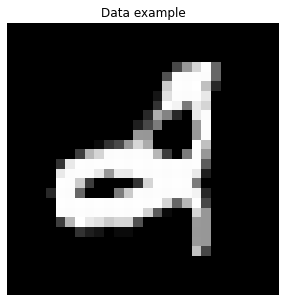

In [4]:
## Data loader(배치화 하기 위하여 사용)
batch_size=100

train_loader = DataLoader(dataset=train_datasets, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_datasets, batch_size=batch_size, shuffle=False, drop_last=False)

# 배치화된 데이터 확인
for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
    print(f"{batch_idx}번째 배치")
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(X_batch[0].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title('Data example')
    break
plt.show()

## Model

In [5]:
class MLP_model(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP_model, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.fc1 = torch.nn.Linear(self.input_size, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 32)
        self.fc4 = torch.nn.Linear(32, self.num_classes)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        fc1 = self.fc1(x)
        a1 = self.relu(fc1)
        fc2 = self.fc2(a1)
        a2 = self.relu(fc2)
        fc3 = self.fc3(a2)
        a3 = self.relu(fc3)
        fc4 = self.fc4(a3) # 마지막 layer에 softmax를 사용하지 않는이유: CrossEntropyLoss()에 softmax 연산이 포함됨
        return fc4

In [6]:
# Hyper parameters
input_dim = np.array(train_datasets.data.shape[-2:]).prod()
num_classes = len(train_datasets.classes)
num_epochs = 20
learning_rate = 0.05

In [7]:
model = MLP_model(input_size=input_dim, num_classes=num_classes)

In [8]:
# 손실함수 생성
criterion = torch.nn.CrossEntropyLoss() # CrossEntropyLoss()에 softmax 연산이 포함됨

# Optimizer 생성
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

## Training

In [9]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    # 배치 학습
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        
        X_batch = X_batch.reshape(batch_size, -1)
        
        output = model(X_batch)
        loss_train = criterion(output, y_batch)
        
        output_softmax = F.softmax(output, dim=1)
        train_pred_class = torch.argmax(output_softmax.data, dim=1)
        acc_train = (train_pred_class == y_batch).numpy().mean()
        
        loss_train.backward()
        optimizer.step()
        
    train_loss_list.append(loss_train.item())
    train_acc_list.append(acc_train)
    
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = []
        for test_batch_idx, (X_test_batch, y_test_batch) in enumerate(test_loader): 
            X_test_batch = X_test_batch.reshape(batch_size, -1)

            test_output = model(X_test_batch)
            loss_test = criterion(test_output, y_test_batch)
            
            test_output_softmax = F.softmax(test_output, dim=1)
            test_pred_class = torch.argmax(test_output_softmax.data, dim=1)

            test_loss.append(loss_test.item())
            correct += (test_pred_class == y_test_batch).sum().item()
            total += len(y_test_batch)
        test_acc_list.append(correct/total)
        test_loss_list.append(np.array(test_loss).mean())
    
    
    print(f"Epoch:[{epoch+1}] train_loss: {train_loss_list[-1]:.3f}, train_acc: {train_acc_list[-1]*100:.2f}% /", end=' ')
    print(f"test_loss: {test_loss_list[-1]:.3f}, test_acc: {test_acc_list[-1]*100:.2f}%")

Epoch:[1] train_loss: 0.430, train_acc: 86.00% / test_loss: 0.408, test_acc: 87.49%
Epoch:[2] train_loss: 0.229, train_acc: 92.00% / test_loss: 0.273, test_acc: 92.02%
Epoch:[3] train_loss: 0.433, train_acc: 89.00% / test_loss: 0.210, test_acc: 93.79%
Epoch:[4] train_loss: 0.148, train_acc: 95.00% / test_loss: 0.176, test_acc: 94.83%
Epoch:[5] train_loss: 0.136, train_acc: 94.00% / test_loss: 0.136, test_acc: 96.06%
Epoch:[6] train_loss: 0.133, train_acc: 98.00% / test_loss: 0.124, test_acc: 96.42%
Epoch:[7] train_loss: 0.042, train_acc: 98.00% / test_loss: 0.118, test_acc: 96.52%
Epoch:[8] train_loss: 0.073, train_acc: 98.00% / test_loss: 0.106, test_acc: 96.82%
Epoch:[9] train_loss: 0.063, train_acc: 97.00% / test_loss: 0.101, test_acc: 96.95%
Epoch:[10] train_loss: 0.076, train_acc: 98.00% / test_loss: 0.100, test_acc: 97.24%
Epoch:[11] train_loss: 0.048, train_acc: 98.00% / test_loss: 0.089, test_acc: 97.43%
Epoch:[12] train_loss: 0.062, train_acc: 97.00% / test_loss: 0.104, test_a

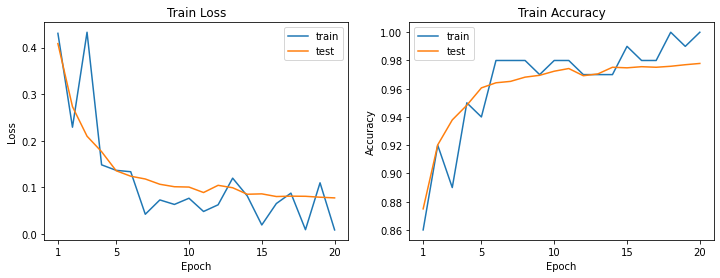

In [10]:
## Loss
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(range(1, 21), train_loss_list, label='train')
axes[0].plot(range(1, 21), test_loss_list, label='test')
axes[0].set_title('Train Loss', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_xticks([1] + list(range(5, 21, 5)))
axes[0].legend()

axes[1].plot(range(1, 21), train_acc_list, label='train')
axes[1].plot(range(1, 21), test_acc_list, label='test')
axes[1].set_title('Train Accuracy', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks([1] + list(range(5, 21, 5)))
axes[1].legend()

plt.show()